# Entrenamiento O3


Una vez que se tienen los datos limpios y procesados, estos pueden ser usados para la generación de los modelos. A continuación se muestra el flujo trabajo para la generación de los modelos:

<img src="./gen_modelos.png" style="height:300px">

Los modelos utilizados son del tipo __supervisado___, esto quiere decir que se necesita tener el valor real para poder generar los modelos, este valor corresponde a la columna del contaminante a pronosticar a una hora específica.  

Una vez que se tiene esta columna identificado, es necesario dividir los datos de entrenamiento en dos conjuntos: de __entrenamiento__ y __prueba__. La razón de dividirlos es para poder cuantiﬁcar el desempeño y el correcto funcionamiento de los modelos. El conjunto de entrenamiento correspondió al __80%__ de los datos totales y en éste se ejecutarán los modelos estadísticos para obtener los árboles de decisión y con el conjunto de prueba que correspondió al __20%__ restante, se comparará el pronóstico de los modelos con el valor real.

Con el conjunto de entrenamiento se ejecutaron todas las pruebas realizadas, aplicando los modelos de machine learning ya mencionados. Los modelos se optimizaron para tener un correcto pronóstico de valores alrededor del nivel de contaminación de la contingencia ambiental. Los modelos de los tres contaminantes son capaces de generar el pronóstico hasta de 24 horas, para cada hora se generó un modelo de manera que se generaron 24 modelos.


### Métricas de Valoración
Para medir el desempeño de un modelo de pronóstico es importante contar con una métrica de desempeño. Medir el desempeño del pronóstico es importante para saber que los métodos y características con los que trabaja el pronóstico son los adecuados. Además, calcular el desempeño de los modelos nos ayudará en la búsqueda de partes del pronóstico que no trabajen de manera óptima y con esto tomar decisiones para mejorar el desempeño del mismo. Las principales métricas usadas para medir el desempeño del modelo son el RMSE que nos indica qué tanto se aleja la predicción del valor real, la R2 que determina la calidad del modelo para replicar los resultados y la proporción de variación de los resultados que puede explicarse por el modelo y la precisión que nos indica cuántos falsos positivos genera el modelo es decir, cuántas contingencias son pronosticadas incorrectamente por cada contingencia pronosticada correctamente.


__Pasos y descripción general del notebook__


- __Datos recibidos:__ Limpieza de datos inicial
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import missingno as msn

pd.options.mode.chained_assignment = None 

from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.datasets import make_regression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer

import seaborn as sn
from sklearn.metrics import confusion_matrix as confussion_matrix_function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import seaborn as sns
import random as rd
import time

#### Hacemos una función para obtenner el -promedio- de los dos modelos

In [2]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

Definimos el score [specifity](https://es.wikipedia.org/wiki/Especificidad_(epidemiología)) que se basa en el número de **TP** por cada **FP + FN**.

 $$Especifity = \frac{TP}{FP + FN}$$

## Hacemos una función para graficar

In [3]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

## Cargamos los modelos ya entrenados:

In [4]:
conta = 'O3'

In [5]:
model = [0 for col in range(25)]
modelq = [0 for col in range(25)]

#### Cargamos los datos:

In [6]:
data_hour_merge = pd.read_csv(str("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/"+
                                  "contaminación/pipeline_norberto_11horas/datos/datos_modelos_"+conta+".csv"))

In [7]:
data_hour_merge['fecha'] = pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M:%S')
data_hour_merge["hora"] = [row["fecha"].hour for index, row in data_hour_merge.iterrows()]

### Filtro de contingencia

In [8]:
data_hour_merge.columns.tolist()

['TMP_mean_frcst_6',
 'CO_9.0_mean',
 'CO_8.0_mean',
 'O3_72.0_min',
 'TMP_mean_frcst_11',
 'NOX_7.0_min',
 'RH_mean_frcst_12',
 'TMP_mean',
 'O3_max',
 'O3_1.0_max',
 'PM25mean_mean',
 'O3_2.0_max',
 'TMP_49.0_min',
 'TMP_mean_frcst_10',
 'CO_6.0_min',
 'WSP_mean_frcst_10',
 'TMP_mean_frcst_1',
 'hora_24.0',
 'RH_46.0_min',
 'O3_51.0_mean',
 'WSP_mean_frcst_2',
 'RH_mean_frcst_3',
 'CO_6.0_mean',
 'TMP_26.0_min',
 'hora',
 'RH_mean',
 'PM2.5_5.0_min',
 'TMP_27.0_min',
 'WSP_mean',
 'TMP_51.0_mean',
 'NO2_mean',
 'CO_8.0_min',
 'TMP_51.0_min',
 'TMP_23.0_mean',
 'WSP_mean_frcst_9',
 'TMP_mean_frcst_7',
 'CO_7.0_mean',
 'PM10mean_mean',
 'fecha',
 'PM25mean_min',
 'WSP_mean_frcst_23',
 'TMP_46.0_max',
 'TMP_22.0_mean',
 'WSP_mean_frcst_11',
 'PM25mean_max',
 'O3_72.0_max',
 'TMP_50.0_mean',
 'O3_max_frcst_1',
 'O3_max_frcst_2',
 'O3_max_frcst_3',
 'O3_max_frcst_4',
 'O3_max_frcst_5',
 'O3_max_frcst_6',
 'O3_max_frcst_7',
 'O3_max_frcst_8',
 'O3_max_frcst_9',
 'O3_max_frcst_10',
 'O3_max

In [9]:
data_hour_merge.loc[data_hour_merge["O3_max_frcst_11"]>142, 'class'] = 1
data_hour_merge.loc[data_hour_merge["O3_max_frcst_11"]<=142, 'class'] = 0

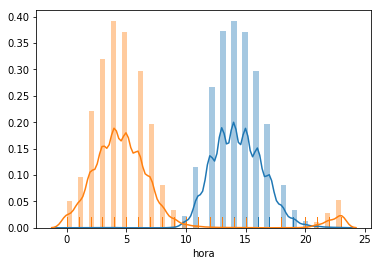

In [10]:
sns.distplot(data_hour_merge["hora"][data_hour_merge["O3_max_frcst_1"]>81.38], kde=True, rug=True)
sns.distplot(data_hour_merge["hora"][data_hour_merge["O3_max_frcst_11"]>81.38], kde=True, rug=True)

En contraste con la distriubción de precontingencias del Ozono, en el caso del PM10 y PM2.5, estas están distribuidas a lo largo del día, presumiblemente debido a que se considera el promedio móvil de las últimas 24 horas y no la medición puntual. 

> __Por este motivo vamos a hacer un 24 modelos, que pronostiquen a las 4am para cada hora del día.__

#### Filtramos por el día donnde se va a aplicar el pronóstico:

Definimos la lista de los targets:

### No aplica para PM10 o PM25
ya que la distribuciónn de contingencias es a lo largo del día

Borramos las columnas del target.

In [11]:
target = "O3_max_frcst_"

lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [12]:
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [13]:
conta = 'O3'

## Training and verificationn split

Separamos en conjunto de verificacion y training según el anio:

In [14]:
data_hour_merge['fecha'] = pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M:%S')
data_hour_merge["anio"] = [row["fecha"].year for index, row in data_hour_merge.iterrows()]
data_hour_merge["mes"] = [row["fecha"].month for index, row in data_hour_merge.iterrows()]

In [15]:
data_hour_merge_training = data_hour_merge[data_hour_merge["anio"].isin([2018, 2017,2016,2015])]
data_hour_merge_verification = data_hour_merge[data_hour_merge["anio"].isin([2019,])]

In [16]:
data_hour_merge_training.drop("fecha",axis=1,inplace=True)
data_hour_merge_verification.drop("fecha",axis=1,inplace=True)
data_hour_merge_training.drop("anio",axis=1,inplace=True)
data_hour_merge_verification.drop("anio",axis=1,inplace=True)

In [17]:
hora = 11
dataset = data_hour_merge_verification.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X_verification = dataset.loc[:, dataset.columns != "class"]
y_verification = dataset["class"]

In [18]:
del data_hour_merge_verification

In [19]:
del data_hour_merge

# Clasificador:

#### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [20]:
from sklearn.metrics import confusion_matrix as confussion_matrix_function
from sklearn.model_selection import GridSearchCV

In [21]:
hora = 11

dataset = data_hour_merge_training.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X = dataset.loc[:, dataset.columns != "class"]
y = dataset["class"]

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))

In [22]:
model3= selection_model = XGBClassifier(
 n_estimators=550,
 max_depth=10,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=2)
# eval model

In [23]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [24]:
model3.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.006256	validation_0-logloss:0.600088	validation_1-error:0.007993	validation_1-logloss:0.600241
[1]	validation_0-error:0.005312	validation_0-logloss:0.523854	validation_1-error:0.006371	validation_1-logloss:0.524285
[2]	validation_0-error:0.004766	validation_0-logloss:0.460048	validation_1-error:0.007066	validation_1-logloss:0.460791
[3]	validation_0-error:0.004617	validation_0-logloss:0.406165	validation_1-error:0.006603	validation_1-logloss:0.407087
[4]	validation_0-error:0.004468	validation_0-logloss:0.360117	validation_1-error:0.006718	validation_1-logloss:0.361335
[5]	validation_0-error:0.004319	validation_0-logloss:0.320461	validation_1-error:0.005908	validation_1-logloss:0.321924
[6]	validation_0-error:0.004369	validation_0-logloss:0.286073	validation_1-error:0.006023	validation_1-logloss:0.287768
[7]	validation_0-error:0.00427	validation_0-logloss:0.255967	validation_1-error:0.005792	validation_1-logloss:0.257958
[8]	validation_0-error:0.004071	validatio

[69]	validation_0-error:0.000447	validation_0-logloss:0.004207	validation_1-error:0.005676	validation_1-logloss:0.016464
[70]	validation_0-error:0.000447	validation_0-logloss:0.00411	validation_1-error:0.00556	validation_1-logloss:0.016436
[71]	validation_0-error:0.000447	validation_0-logloss:0.004012	validation_1-error:0.00556	validation_1-logloss:0.01646
[72]	validation_0-error:0.000447	validation_0-logloss:0.003931	validation_1-error:0.005676	validation_1-logloss:0.016382
[73]	validation_0-error:0.000348	validation_0-logloss:0.003835	validation_1-error:0.005676	validation_1-logloss:0.016394
[74]	validation_0-error:0.000298	validation_0-logloss:0.003721	validation_1-error:0.00556	validation_1-logloss:0.016388
[75]	validation_0-error:0.000248	validation_0-logloss:0.003624	validation_1-error:0.005676	validation_1-logloss:0.016397
[76]	validation_0-error:0.000248	validation_0-logloss:0.003542	validation_1-error:0.005676	validation_1-logloss:0.016424
[77]	validation_0-error:0.000248	vali

[138]	validation_0-error:0	validation_0-logloss:0.001631	validation_1-error:0.00556	validation_1-logloss:0.017403
[139]	validation_0-error:0	validation_0-logloss:0.001622	validation_1-error:0.005676	validation_1-logloss:0.017421
[140]	validation_0-error:0	validation_0-logloss:0.001609	validation_1-error:0.00556	validation_1-logloss:0.017437
[141]	validation_0-error:0	validation_0-logloss:0.001596	validation_1-error:0.005676	validation_1-logloss:0.017476
[142]	validation_0-error:0	validation_0-logloss:0.001584	validation_1-error:0.00556	validation_1-logloss:0.017464
[143]	validation_0-error:0	validation_0-logloss:0.00157	validation_1-error:0.00556	validation_1-logloss:0.017435
[144]	validation_0-error:0	validation_0-logloss:0.001562	validation_1-error:0.00556	validation_1-logloss:0.017404
[145]	validation_0-error:0	validation_0-logloss:0.001551	validation_1-error:0.00556	validation_1-logloss:0.017414
[146]	validation_0-error:0	validation_0-logloss:0.001542	validation_1-error:0.00556	val

[210]	validation_0-error:0	validation_0-logloss:0.001096	validation_1-error:0.00556	validation_1-logloss:0.018083
[211]	validation_0-error:0	validation_0-logloss:0.001092	validation_1-error:0.00556	validation_1-logloss:0.018056
[212]	validation_0-error:0	validation_0-logloss:0.001087	validation_1-error:0.00556	validation_1-logloss:0.018068
[213]	validation_0-error:0	validation_0-logloss:0.001083	validation_1-error:0.00556	validation_1-logloss:0.018099
[214]	validation_0-error:0	validation_0-logloss:0.001079	validation_1-error:0.00556	validation_1-logloss:0.0181
[215]	validation_0-error:0	validation_0-logloss:0.001071	validation_1-error:0.00556	validation_1-logloss:0.018104
[216]	validation_0-error:0	validation_0-logloss:0.001067	validation_1-error:0.00556	validation_1-logloss:0.01815
[217]	validation_0-error:0	validation_0-logloss:0.001064	validation_1-error:0.00556	validation_1-logloss:0.018109
[218]	validation_0-error:0	validation_0-logloss:0.00106	validation_1-error:0.00556	validati

[283]	validation_0-error:0	validation_0-logloss:0.000867	validation_1-error:0.00556	validation_1-logloss:0.01844
[284]	validation_0-error:0	validation_0-logloss:0.000865	validation_1-error:0.00556	validation_1-logloss:0.018472
[285]	validation_0-error:0	validation_0-logloss:0.000862	validation_1-error:0.00556	validation_1-logloss:0.018475
[286]	validation_0-error:0	validation_0-logloss:0.00086	validation_1-error:0.00556	validation_1-logloss:0.0185
[287]	validation_0-error:0	validation_0-logloss:0.000857	validation_1-error:0.00556	validation_1-logloss:0.0185
[288]	validation_0-error:0	validation_0-logloss:0.000855	validation_1-error:0.00556	validation_1-logloss:0.018513
[289]	validation_0-error:0	validation_0-logloss:0.000852	validation_1-error:0.00556	validation_1-logloss:0.018514
[290]	validation_0-error:0	validation_0-logloss:0.00085	validation_1-error:0.00556	validation_1-logloss:0.018535
[291]	validation_0-error:0	validation_0-logloss:0.000847	validation_1-error:0.00556	validation_

[356]	validation_0-error:0	validation_0-logloss:0.000738	validation_1-error:0.00556	validation_1-logloss:0.018726
[357]	validation_0-error:0	validation_0-logloss:0.000737	validation_1-error:0.00556	validation_1-logloss:0.018725
[358]	validation_0-error:0	validation_0-logloss:0.000735	validation_1-error:0.00556	validation_1-logloss:0.018724
[359]	validation_0-error:0	validation_0-logloss:0.000734	validation_1-error:0.00556	validation_1-logloss:0.018692
[360]	validation_0-error:0	validation_0-logloss:0.000733	validation_1-error:0.00556	validation_1-logloss:0.018683
[361]	validation_0-error:0	validation_0-logloss:0.000731	validation_1-error:0.00556	validation_1-logloss:0.018686
[362]	validation_0-error:0	validation_0-logloss:0.00073	validation_1-error:0.00556	validation_1-logloss:0.018688
[363]	validation_0-error:0	validation_0-logloss:0.000729	validation_1-error:0.00556	validation_1-logloss:0.018708
[364]	validation_0-error:0	validation_0-logloss:0.000728	validation_1-error:0.00556	valid

[428]	validation_0-error:0	validation_0-logloss:0.000654	validation_1-error:0.00556	validation_1-logloss:0.019118
[429]	validation_0-error:0	validation_0-logloss:0.000652	validation_1-error:0.00556	validation_1-logloss:0.019129
[430]	validation_0-error:0	validation_0-logloss:0.000652	validation_1-error:0.00556	validation_1-logloss:0.019116
[431]	validation_0-error:0	validation_0-logloss:0.000651	validation_1-error:0.00556	validation_1-logloss:0.019126
[432]	validation_0-error:0	validation_0-logloss:0.00065	validation_1-error:0.00556	validation_1-logloss:0.019096
[433]	validation_0-error:0	validation_0-logloss:0.000649	validation_1-error:0.00556	validation_1-logloss:0.019088
[434]	validation_0-error:0	validation_0-logloss:0.000649	validation_1-error:0.00556	validation_1-logloss:0.019097
[435]	validation_0-error:0	validation_0-logloss:0.000648	validation_1-error:0.00556	validation_1-logloss:0.019086
[436]	validation_0-error:0	validation_0-logloss:0.000648	validation_1-error:0.00556	valid

[501]	validation_0-error:0	validation_0-logloss:0.000599	validation_1-error:0.00556	validation_1-logloss:0.019351
[502]	validation_0-error:0	validation_0-logloss:0.000598	validation_1-error:0.00556	validation_1-logloss:0.019376
[503]	validation_0-error:0	validation_0-logloss:0.000598	validation_1-error:0.00556	validation_1-logloss:0.019381
[504]	validation_0-error:0	validation_0-logloss:0.000597	validation_1-error:0.00556	validation_1-logloss:0.019366
[505]	validation_0-error:0	validation_0-logloss:0.000597	validation_1-error:0.00556	validation_1-logloss:0.019394
[506]	validation_0-error:0	validation_0-logloss:0.000596	validation_1-error:0.00556	validation_1-logloss:0.019394
[507]	validation_0-error:0	validation_0-logloss:0.000595	validation_1-error:0.00556	validation_1-logloss:0.019383
[508]	validation_0-error:0	validation_0-logloss:0.000594	validation_1-error:0.00556	validation_1-logloss:0.019403
[509]	validation_0-error:0	validation_0-logloss:0.000594	validation_1-error:0.00556	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=2, missing=None, n_estimators=550, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=2, silent=None,
       subsample=0.8, verbosity=1)

In [25]:
def specifity(y_true_function,y_pred_function):
    
    """
    
    
    """
    try:
        tn, fp, fn, tp = confussion_matrix_function(y_true_function.tolist(), y_pred_function.tolist()).ravel()
        score = (tp*100) / (fn+(np.exp(fp)))
        return score
    except:
        return 0

 # score will negate the return value of my_custom_loss_func,
# which will be np.log(2), 0.693, given the values for X
# and y defined below.
specifity_scorer = make_scorer(specifity, greater_is_better=True)

Accuracy: 0


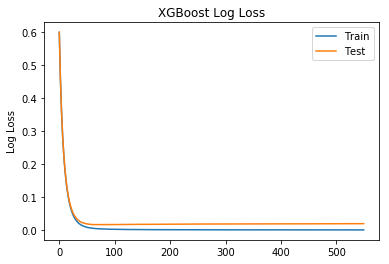

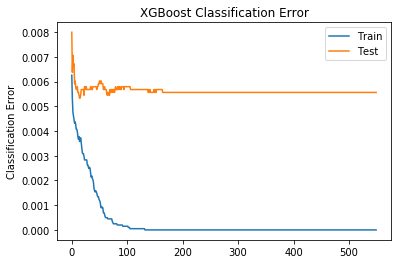

In [ ]:
# make predictions for test data
y_pred = model3.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = specifity(predictions,y_test)
print("Accuracy: " +str(accuracy))
# retrieve performance metrics
results = model3.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)


# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

## GridSearch

## Plot

In [ ]:
def model_specifity_ploter(df_specifity,score):
    """


    """

    #Gráficas
    specifity_test_plot = df_specifity.mean(axis=0).values
    df_specifity=df_specifity.T

    plt.subplots(figsize=(8, 3))
    plt.plot(values_search, specifity_test_plot,color="royalblue")
    plt.title(str(score))


  
    plt.tight_layout()
    plt.show() 

### Verification

In [ ]:
def verification_model_score(
                            df,target,n_iteraciones,
                            iteraciones,n_iteracion):
    """
    
    
    """
    dataset = df.copy()
    #dataset.drop(["fecha"],axis=1,inplace=True)
    dataset.dropna(inplace=True)
    dataset.drop(lista[:],axis=1,inplace=True)

    X = dataset.loc[:, dataset.columns != target]
    y = dataset[target]

    #Definimos los conjuntos de prueba:

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))
    #Definimos los conjuntos de prueba:
    iteraciones = [entrada for entrada in range(n_iteraciones)] ##definimos el número de iteraciones
    
    df_confussion_test = pd.DataFrame(index=iteraciones, columns=["tn","fp","fn","tp"])
    df_confussion_mean_test = pd.DataFrame(index=[0,1], columns=[0,1])

    for iteracion in iteraciones:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))
        model = XGBClassifier(params=parameters[n_iteracion])#definimos los parametros
        model_train = model.fit(X_train, y_train)#fit
        pred_test = model_train.predict(X_test)
        #confussion matrix
        df_confussion_test.iloc[iteracion,:] = confussion_matrix_function(y_test,pred_test).ravel()

    print(df_confussion_test)
    
    df_confussion_mean_test.iloc[0,:] = df_confussion_test.describe().iloc[1,0:2].values
    df_confussion_mean_test.iloc[1,:] = df_confussion_test.describe().iloc[1,2:4].values
    df_confussion_mean_test = df_confussion_mean_test.apply(pd.to_numeric, errors='ignore')

    sn.heatmap(df_confussion_mean_test, annot=True)

In [ ]:
hora = 11

dataset = data_hour_merge_training.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X = dataset.loc[:, dataset.columns != "class"]
y = dataset["class"]

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))

In [ ]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [ ]:
def xgboost_autoparameter_tunning(
                                df,target,parameter_grid,resamples,
                                parameters_list,score=specifity): 
    
    intentos = [number for number in range(resamples)]
    parameters_numbers_position = [i for i in range(len(parameters))]
    df_specifity = pd.DataFrame(columns=parameters_numbers_position,index=intentos)
    toolbar_width = len(intentos)
    
    
    ## progress bar 
    l = len(intentos)
    # Initial call to print 0% progress
    printProgressBar(0, l, prefix = 'Intentos:', suffix = '', length = 50)

    for intento in range(len(intentos)):
        
        X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.3,   
                                                                        random_state=rd.randint(100,200)) 
        specifity_test_list = []# para cada conjunto de parametr

        for parameter_value in range(len(parameters_numbers_position)): ## iteramos sobre el parámetro deseado 

            model = XGBClassifier(**parameters[parameter_value])
            train_model = model.fit(X_training, y_training) ##model fit

            pred_test = train_model.predict(X_testing)  # predict verification

            specifity_test = specifity(y_testing,pred_test)## specifity model
            specifity_test_list.append(specifity_test)# specifity of search values and numbers
            
            
        time.sleep(0.1)
            # Update Progress Bar
        printProgressBar(intento + 1, l, prefix = 'Intentos:', suffix = '', length = 50)

            #print(specifity_test)
        specifity_test_list
        #print(df_specifity)

        df_specifity.loc[intento,:] = specifity_test_list
        
        
        
    df_specifity = df_specifity.apply(pd.to_numeric, errors = 'coerce')
    time.sleep(0)
    maximo = max(df_specifity.mean(axis=0))

    pos_maximum = [i for i,j in enumerate(df_specifity.mean(axis=0)) if j == maximo][0]
    maximo = round(maximo,2)

    #print(round(df_specifity.mean(axis=0),2))

    #print(df_confussion_mean)
    model_specifity_ploter(df_specifity,specifity)
    print()
    print("El máximo es para n="+ str(pos_maximum) + "  k=" + str(parameters[pos_maximum]) + 
          " con un " +"score"+"=  " +  str(maximo))

# booster

Intentos: |██████████████████████████████████████████████████| 100.0% 


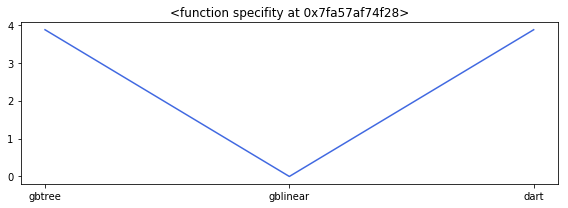


El máximo es para n=0  k={'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 10, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logistic', 'verbosity': 1} con un score=  3.87


In [ ]:
values_search=["gbtree","gblinear","dart"]
parameter_grid=values_search
parameters = [{ "booster":Serch_parameter, "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.01,"max_delta_step":0, 
 "max_depth":10,"n_estimators":100, "n_jobs":100, "nthread":None,
 "objective":'binary:logistic', "verbosity":1} for Serch_parameter in parameter_grid]

xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,20,values_search)

## Verification

     tn  fp  fn  tp
0  8560   3  47  23
1  8553   7  49  24
2  8548  17  47  21
3  8558  11  41  23
4  8559   5  43  26


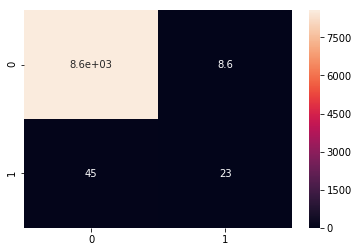

In [ ]:
verification_model_score(data_hour_merge_training,"class",5,parameters,0)

### min_child_weight

Intentos: |██████████████████████████████████████████████████| 100.0% 


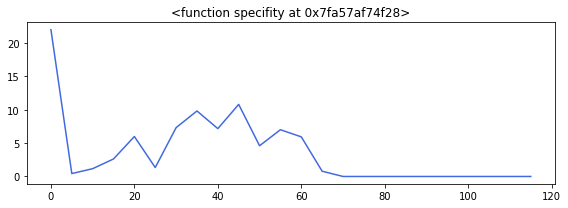


El máximo es para n=0  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.9, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 65, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  22.01


In [ ]:
parameter_grid=[i for i in range(0,120,5)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.9,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":Serch_parameter, "missing":None,"n_estimators":65, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]

xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,5,parameters)

     tn  fp  fn  tp
0  8566   3  43  21
1  8574   8  33  18
2  8554   8  47  24
3  8543  28  42  20
4  8558  10  41  24


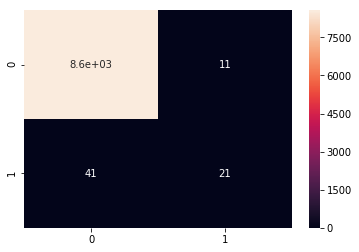

In [ ]:
verification_model_score(data_hour_merge_training,"class",5,parameters,0)

### n_estimators

Intentos: |██████████████████████████████████████████████████| 100.0% 


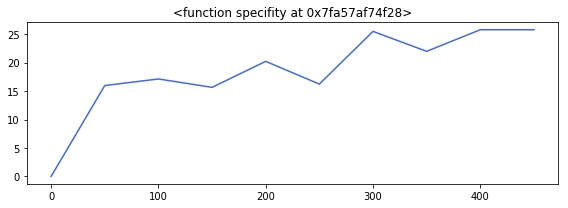


El máximo es para n=8  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 400, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  25.77


In [ ]:
parameter_grid=[i for i in range(0,500,50)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0, "missing":None,"n_estimators":Serch_parameter, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

     tn  fp  fn  tp
0  8553   7  49  24
1  8548   8  54  23
2  8570   7  44  12


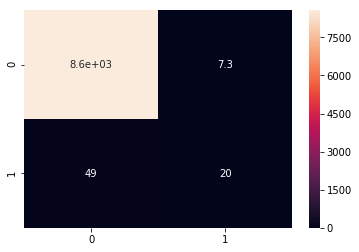

In [ ]:
verification_model_score(data_hour_merge_training,"class",3,parameters,9)

#### Gamma

Intentos: |██████████████████████████████████████████████████| 100.0% 


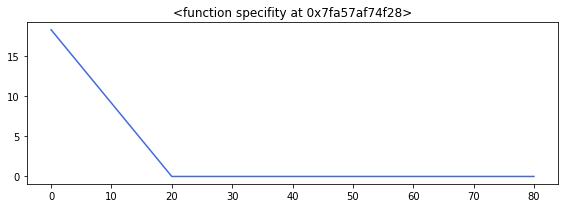


El máximo es para n=0  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  18.32


In [ ]:
parameter_grid=[i for i in range(0,100,20)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":Serch_parameter, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

      tn  fp  fn  tp
0   8567   9  36  21
1   8568  10  40  15
2   8565   6  41  21
3   8554   4  47  28
4   8553   6  51  23
5   8564   6  43  20
6   8568   9  36  20
7   8563   5  44  21
8   8584   5  29  15
9   8559  11  46  17
10  8561   7  47  18
11  8566   3  45  19
12  8555   4  49  25
13  8564   5  43  21


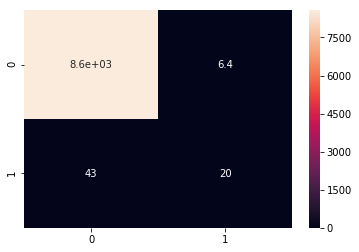

In [ ]:
verification_model_score(data_hour_merge_training,"class",14,parameters,0)

## max_depth

Intentos: |██████████████████████████████████████████████████| 100.0% 


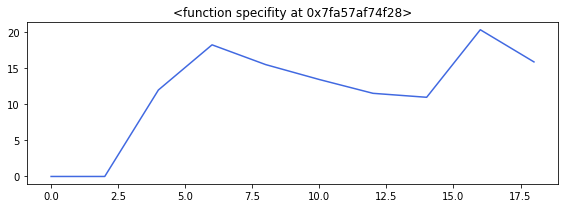


El máximo es para n=8  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  20.34


In [ ]:
parameter_grid=[i for i in range(0,20,2)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":Serch_parameter, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

     tn  fp  fn  tp
0  8551   9  50  23
1  8570   5  35  23
2  8564   2  53  14
3  8551   6  53  23
4  8557   6  45  25


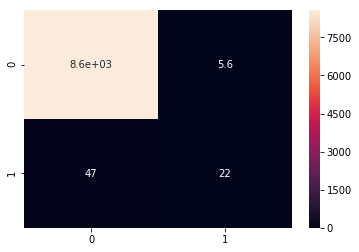

In [ ]:
verification_model_score(data_hour_merge_training,"class",5,parameters,3)

## reg_alpha

Intentos: |██████████████████████████████████████████████████| 100.0% 


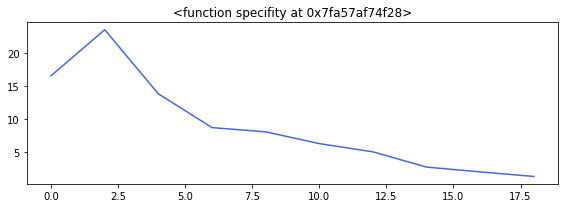


El máximo es para n=1  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 2, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  23.54


In [ ]:
parameter_grid=[i for i in range(0,20,2)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":6, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":Serch_parameter,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

     tn  fp  fn  tp
0  8553   7  54  19
1  8564   2  53  14


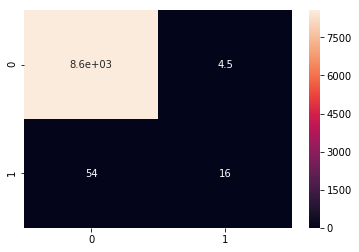

In [ ]:
verification_model_score(data_hour_merge_training,"class",2,parameters,0)

### scale_pos_weight

In [ ]:
parameter_grid=[i/100 for i in range(0,100,10)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":Serch_parameter,"max_delta_step":0, 
 "max_depth":6, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,3,parameters)

In [ ]:
verification_model_score(data_hour_merge_training,"class",5,parameters,8)